# Email Spam Classifier using Python

The advent of communication using the internet has brought upon us the problem of spam. This project attempts to create a classifier which automatically classifies whether a given email is spam or not. We will be using a Naive Bayes classifier, which is a classifier that uses Bayes' theorem.

We shall be using the word "ham" to refer to emails that are not spam for the rest of this project.

## Bayes' theorem

<img src="https://latex.codecogs.com/svg.latex?P(A&space;|&space;B)&space;=&space;\frac{P(B&space;|&space;A)\cdot&space;P(A)&space;}{P(B)}" title="P(A | B) = \frac{P(B | A)\cdot P(A) }{P(B)}" />

Bayes' theorem provides a concrete way to calculate the proability of an event occuring based on evidence. For more information on Bayes' theorem check out this [video](https://www.youtube.com/watch?v=HZGCoVF3YvM&list=PLicJioO1iPeU8NBMb7eNhAsGigVRWv2Dv&index=26) by [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) on YouTube.

Consider an email that has the words {w1, w2, w3, ..., wn}. The probability of the email being spam would then be P(spam|w1<sub>&#8898;</sub>w2<sub>&#8898;</sub>......<sub>&#8898;</sub>wn), which can be expressed as follows.

<img src="https://latex.codecogs.com/svg.latex?P(spam&space;|&space;w1\cap&space;w2\cap&space;...wn&space;)&space;=&space;\frac{P(w1\cap&space;w2\cap&space;...wn&space;|&space;spam)\cdot&space;P(spam)&space;}{P(w1\cap&space;w2\cap&space;...wn)}" title="P(spam | w1\cap w2\cap ...wn ) = \frac{P(w1\cap w2\cap ...wn | spam)\cdot P(spam) }{P(w1\cap w2\cap ...wn)}" />

For this classifier, we shall assume that each word in an email occurs independently of each other (which leads to the "naivety" of the classifier). So the equation simplifies to the following.

<img src="https://latex.codecogs.com/svg.latex?P(spam&space;|&space;w1\cap&space;w2\cap&space;...wn&space;)&space;=&space;\frac{P(w1&space;|&space;spam)\cdot&space;P(w2&space;|&space;spam)\cdot&space;...&space;P(w2&space;|&space;spam)&space;\cdot&space;P(spam)&space;}{P(w1)\cdot&space;P(w1)\cdot&space;...P(wn)}" title="P(spam | w1\cap w2\cap ...wn ) = \frac{P(w1 | spam)\cdot P(w2 | spam)\cdot ... P(w2 | spam) \cdot P(spam) }{P(w1)\cdot P(w1)\cdot ...P(wn)}" />

Here, (wx|spam) refers to the probability of a word occuring in all the spam emails in the dataset. Instead of probabilities, we shall be using the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=In%20information%20retrieval%2C%20tf%E2%80%93idf,in%20a%20collection%20or%20corpus.) as a feature.

## Dataset

We shall be Apache SpamAssassin's public corpus of emails as a dataset to train our models. It contains roughly 6000 raw emails, with all the headers present. The emails have been classified as spam or ham, with around 30% of the data being spam.

https://spamassassin.apache.org/old/publiccorpus/

## Libraries used

* os: Used to interact with the operating system.
* email: Used to load and parse emails.
* BeatifulSoup 4.9.1: Used to convert HTML to plaintext.
* warnings: Used to override a specific warning.
* urlextract 1.1.0: Used to search for URLs within strings.
* re 2.2.1: Used to implement regular expressions.
* nltk 3.5: Used to implement certain natural language processing techniques.
* wordcloud 1.8.0: Used to visualize most frequent words.
* matplotlib 3.3.1: Used to visualize the data.
* numpy 1.19.1: Used to handle arrays.
* sklearn 0.23.2: Used to perform machine learning techniques on the data.
* seaborn 0.11.0: Used to visualize the results as a heatmap

In [1]:
import os
dir_path = os.getcwd()
import email
import email.policy as policy
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from urlextract import URLExtract
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

## Loading the Dataset and Preprocessing

The following functions load the dataset from memory, and strip the raw emails down to plaintext. Some emails have applications embedded, and some have unknown encoding. We shall be discarding these emails from the dataset.

In [2]:
def multipart_to_text(mail):
    for part in mail.get_payload():
        if part.get_content_type() in ["text/plain", "text/html"]:
            return BeautifulSoup(part.get_content()).get_text().replace("\n\n", " ")
        else:
            return False

In [3]:
def read_mails(dir_name):
    global dir_path
    emails = []
    i = 1
    for filename in os.listdir(dir_name):
        with open("{}\\{}\\{}".format(dir_path, dir_name, filename)) as f:
            try:
                mail = email.parser.Parser(policy = policy.default).parse(f)
                if "multipart" in mail.get_content_type():
                    multipart_str = multipart_to_text(mail)
                    if multipart_str:
                        emails.append(multipart_str)
                else:
                    emails.append(BeautifulSoup(mail.get_content()).get_text().replace("\n\n", " "))
            except:
                continue
            
    return emails

In [4]:
spam_mails = read_mails("Spam\\spam")
spam_2_mails = read_mails("Spam\\spam_2")
ham_mails = read_mails("Ham\\easy_ham")
ham_2_mails = read_mails("Ham\\easy_ham_2")
ham_hard_mails = read_mails("Ham\\hard_ham")

### Example of Ham Email

In [5]:
print(ham_mails[0])

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues 
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com> 
  | I can't reproduce this error. For me it is very repeatable... (like every time, without fail). This is the debug log of the pick happening ... 18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ... Note, if I run the pick command by hand ... delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ... delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002] And the relevant part of my .mh_profile 

### Example of Spam Email

In [6]:
print(spam_mails[0])

       Save up to 70% on Life Insurance.
Why Spend More Than You Have To? Life Quote Savings     
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying life insurance simple and affordable. We Provide FREE Access to The 
      Very Best Companies and The Lowest Rates.   Life Quote Savings is FAST, EASY and 
            SAVES you money! Let us help you get started with the best values in 
            the country on new coverage. You can SAVE hundreds or even thousands 
            of dollars by requesting a FREE quote from Lifequote Savings. Our 
            service will take you less than 5 minutes to complete. Shop and 
            compare. SAVE up to 70% on all types of Life insurance!   Click Here For Your 
            Free Quote! Protecting your family is the best investment you'll ever 
          make!    
If you are in receipt of this email 
      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMO

In [7]:
print("Number of mails in spam =", len(spam_mails))
print("Number of mails in spam_2 =", len(spam_2_mails))
print("Number of mails in easy_ham =", len(ham_mails))
print("Number of mails in easy_ham_2 =", len(ham_2_mails))
print("Number of mails in hard_ham =", len(ham_hard_mails))
print()
print("Total number of spam mails =", len(spam_mails) + len(spam_2_mails))
print("Total number of ham mails =", len(ham_mails) + len(ham_2_mails) + len(ham_hard_mails))
print()
print("Percentage of spam mails =", (len(spam_mails) + len(spam_2_mails)) / (len(spam_mails) + len(spam_2_mails) + len(ham_mails) + len(ham_2_mails) + len(ham_hard_mails)))

Number of mails in spam = 483
Number of mails in spam_2 = 1337
Number of mails in easy_ham = 2499
Number of mails in easy_ham_2 = 1398
Number of mails in hard_ham = 248

Total number of spam mails = 1820
Total number of ham mails = 4145

Percentage of spam mails = 0.30511316010058676


### Preprocessing the text

The following function takes an email and then performs the following operations:
* Replace all URLs with "urllink". This makes it easier to recognise the emails which contain URLs.
* Replace special characters with spaces. Special characters add noise to the emails. Hence, we are getting rid of them.
* Replace all numbers with "numberpresent". This makes it easier to recognise numbers in emails.
* Convert all characters to lowercase.
* Tokenize the email. We convert the email into a list of individual words.
* Remove the stopwords. Words like "the", "a", "they", and so on, add very little information to emails. Hence, we get rid of them.
* Stem the words. This converts all forms of a certain word to one form. For example, words like "sender", "send", "sending" are reduced to their base word "send".

In [8]:
def process_email(email, mail_type):
    #Replace all URLs with "urllink"
    extractor = URLExtract()
    for i in extractor.find_urls(email):
        email = email.replace(i, "urllink")
    
    #Replace special characters with spaces
    email = email.replace("e-mail", "email")
    email = re.sub("[!@#$%^&*()\[\]{};:,./<'\">?\|`~\-=_+]", " ", email)
    
    #Replace all numbers with "numberpresent"
    email = re.sub("[0-9]+", " numberpresent ", email)
    
    #Convert all characters to lowercase
    email = email.lower()
    
    #Tokenize the email, remove the stopwords, and stem the words
    stemmer = PorterStemmer()
    unprocessed_words = [w for w in word_tokenize(email) if w not in stopwords.words('english')]
    words = [stemmer.stem(w) for w in unprocessed_words]
    
    return {"unprocessed_words": unprocessed_words, "words": words, "type": mail_type * 1}

### Splitting the dataset

The following function splits the dataset into train and test datasets. We are doing this in a 70:30 ratio.

In [9]:
def create_datasets(data_list, train_percentage):
    train_set = []
    test_set = []
    for current_data in data_list:
        mail_type = current_data["type"] == "spam"
        split_size = len(current_data["data"]) * train_percentage // 100
        train_set += [process_email(mail, mail_type) for mail in (current_data["data"][0:split_size])]
        test_set += [process_email(mail, mail_type) for mail in (current_data["data"][split_size:])]
    
    unprocessed_ham_words = [mail["unprocessed_words"] for mail in train_set if mail["type"] == 0]
    unprocessed_ham_words += [mail["unprocessed_words"] for mail in test_set if mail["type"] == 0]
    unprocessed_spam_words = [mail["unprocessed_words"] for mail in train_set if mail["type"] == 1]
    unprocessed_spam_words += [mail["unprocessed_words"] for mail in test_set if mail["type"] == 1]
    
    
    return [[[mail["words"] for mail in train_set], [mail["type"] for mail in train_set]], \
            [[mail["words"] for mail in test_set], [mail["type"] for mail in test_set]], \
            unprocessed_ham_words, unprocessed_spam_words]

In [10]:
train_set, test_set, unprocessed_ham_words, unprocessed_spam_words = create_datasets([{"data": spam_mails, "type": "spam"},\
                                                                                {"data": spam_2_mails, "type": "spam"},\
                                                                                {"data": ham_mails, "type": "ham"},\
                                                                                {"data": ham_2_mails, "type": "ham"},\
                                                                                {"data": ham_hard_mails, "type": "ham"}], 70)

In [12]:
unprocessed_spam_words = sum(unprocessed_spam_words, [])
unprocessed_ham_words = sum(unprocessed_ham_words, [])

### Visualization

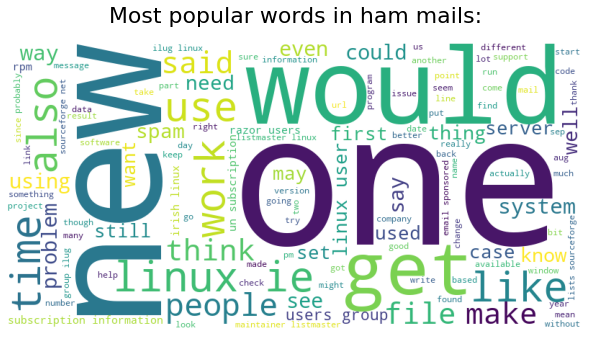

In [13]:
cloud_stopwords = ["urllink", "numberpresent", "mailing", "list"]

cloud = WordCloud(width = 800, height = 400, background_color = "white", stopwords = cloud_stopwords, min_font_size = 10)\
            .generate(" ".join(unprocessed_ham_words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most popular words in ham mails:", fontsize = 22, pad = 20)

plt.show() 

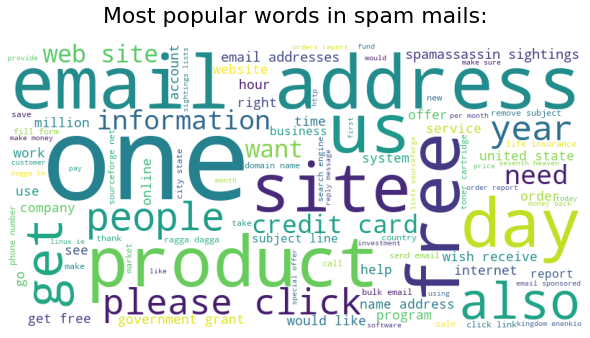

In [14]:
cloud = WordCloud(width = 800, height = 400, background_color = "white", stopwords = cloud_stopwords, min_font_size = 10)\
            .generate(" ".join(unprocessed_spam_words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most popular words in spam mails:", fontsize = 22, pad = 20)

plt.show() 

## Modelling and training the data

We use the TfidfVectorizer function from the nltk module to convert all the emails into a sparse matrix which contain the tfidf of every word present in the training set, with respect to each email. We use the same vectorizer on the test set as well.

In [15]:
def identity_tokenizer(mail):
    return mail

tfidf_vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer, lowercase = False, ngram_range = (1, 1))
train_features = tfidf_vectorizer.fit_transform(train_set[0])
test_features = tfidf_vectorizer.transform(test_set[0])

This data is passed is used to train a Naive Bayes' classifier. We use the MultinomialNB function from scikit-learn to do this. This classifier is then used to classify the test set, and the average accuracy is displayed.

In [16]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_features, train_set[1])

print("Accuracy on the test set  = {:.3f}%".format(nb_classifier.score(test_features, test_set[1]) * 100))
predicted_y = nb_classifier.predict(test_features)

Accuracy on the test set  = 90.792%


## Evaluation of our Model

We use a confusion matrix to indicate the accuracy of our predictions. As shown, we have incorrectly classified 164 emails as ham. And more importantly, we have incorrectly classified 1 email as spam. This means that we would lose one genuine email to our spam box.

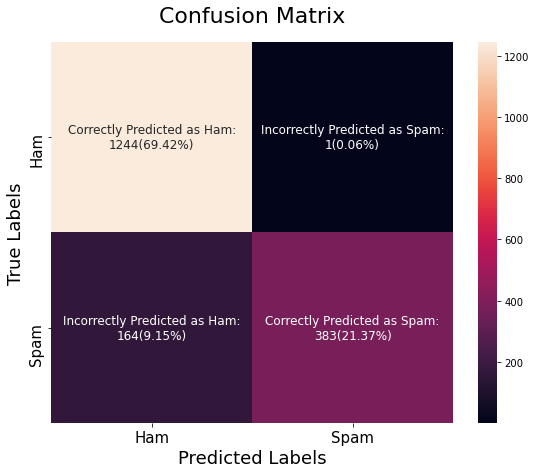

In [17]:
confusion = confusion_matrix(test_set[1], predicted_y)
test_mail_no = len(test_set[0])
confusion_str_matrix = [["Correctly Predicted as Ham:\n{}({:.2f}%)".format(confusion[0][0], confusion[0][0]/test_mail_no*100),\
                         "Incorrectly Predicted as Spam:\n{}({:.2f}%)".format(confusion[0][1], confusion[0][1]/test_mail_no*100)],\
                        ["Incorrectly Predicted as Ham:\n{}({:.2f}%)".format(confusion[1][0], confusion[1][0]/test_mail_no*100),\
                         "Correctly Predicted as Spam:\n{}({:.2f}%)".format(confusion[1][1], confusion[1][1]/test_mail_no*100)]]
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.heatmap(confusion, annot = confusion_str_matrix, fmt = 's', annot_kws = {"size": 12},\
                 xticklabels = ["Ham", "Spam"], yticklabels = ["Ham", "Spam"])
plt.title("Confusion Matrix", fontsize = 22, pad = 20)
plt.xlabel("Predicted Labels", fontsize = 18)
plt.ylabel("True Labels", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

We also use the precision, recall, and F-measure scores as metrics to see how well our model is doing.

In [18]:
scores = precision_recall_fscore_support(test_set[1], predicted_y, average = "binary", pos_label = 1)
print("Precision =", scores[0])
print("Recall\t  =", scores[1])
print("F1 Score  =", scores[2])

Precision = 0.9973958333333334
Recall	  = 0.70018281535649
F1 Score  = 0.8227712137486574


## Illustration of the Classifier

To see the results of our classifier, let us use it on the following spam email.

In [19]:
print(spam_mails[0])

       Save up to 70% on Life Insurance.
Why Spend More Than You Have To? Life Quote Savings     
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying life insurance simple and affordable. We Provide FREE Access to The 
      Very Best Companies and The Lowest Rates.   Life Quote Savings is FAST, EASY and 
            SAVES you money! Let us help you get started with the best values in 
            the country on new coverage. You can SAVE hundreds or even thousands 
            of dollars by requesting a FREE quote from Lifequote Savings. Our 
            service will take you less than 5 minutes to complete. Shop and 
            compare. SAVE up to 70% on all types of Life insurance!   Click Here For Your 
            Free Quote! Protecting your family is the best investment you'll ever 
          make!    
If you are in receipt of this email 
      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMO

In [20]:
names = ["Ham", "Spam"]
print("Classified as:", names[nb_classifier.predict(tfidf_vectorizer.transform([process_email(spam_mails[0], 1)["words"]]))[0]])

Classified as: Spam


As you can see, it was classified as spam, which is correct.

Let us also try to classify a ham email.

In [21]:
print(ham_mails[0])

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues 
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com> 
  | I can't reproduce this error. For me it is very repeatable... (like every time, without fail). This is the debug log of the pick happening ... 18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ... Note, if I run the pick command by hand ... delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ... delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002] And the relevant part of my .mh_profile 

In [22]:
names = ["Ham", "Spam"]
print("Classified as:", names[nb_classifier.predict(tfidf_vectorizer.transform([process_email(ham_mails[0], 0)["words"]]))[0]])

Classified as: Ham


This was also correctly classified as ham.